# Программирование на Python

*Алла Тамбовцева, НИУ ВШЭ*


## Обработка таблиц внутри HTML с `BeautifulSoup` и `pandas`

Импортируем библиотеки и функцию `BeautifulSoup` (понадобятся для примеров ниже):

* `requests` для отправки запроса и получения кода HTML веб-страницы;
* `bs4` для поиска тэгов в коде HTML;
* `pandas` для обработки полученной информации и приведения ее к табличному виду.

In [2]:
import requests
import pandas as pd
from bs4 import BeautifulSoup

В случае работы с таблицами вместо того, чтобы извлекать отдельные строки/ячейки, находя их по тэгам, можно поступать гораздо проще – задействовать функцию `read_html()` из библиотеки `pandas`. Эта функция умеет находить все фрагменты кода HTML с таблицами в тэгах `<table>` и возвращать список датафреймов, содержащих эти таблицы.

Зайдем на сайт Левада-Центра и найдем на [странице](https://www.levada.ru/indikatory/) с индикаторами одобрения органов власти первую таблицу с данными (под первым графиком, имеет индекс 0):

In [3]:
page = requests.get("https://www.levada.ru/indikatory/")
soup = BeautifulSoup(page.text)
tab0 = soup.find_all("table", {"class" : "datatable"})[0]
#print(tab0)

Преобразуем объект `tab0` в строку, так как функция `read_html()` умеет работать только с обычными строками или файлами, а не с объектами `BeautifulSoup`: 

In [4]:
pd.read_html(str(tab0))

[       0        1        2        3        4     5     6     7     8     9    \
 0   8.1999   9.1999  10.1999  11.1999  12.1999   1.2   2.2   3.2   4.2   5.2   
 1  31.0000  53.0000  65.0000  80.0000  79.0000  84.0  75.0  70.0  77.0  72.0   
 2  33.0000  27.0000  20.0000  12.0000  13.0000  10.0  17.0  21.0  15.0  17.0   
 3  37.0000  20.0000  15.0000   8.0000   8.0000   7.0   8.0   9.0   8.0  11.0   
 
    ...      285      286      287      288      289      290      291  \
 0  ...   7.2023   8.2023   9.2023  10.2023  11.2023  12.2023   1.2024   
 1  ...  82.0000  80.0000  80.0000  82.0000  85.0000  83.0000  85.0000   
 2  ...  15.0000  16.0000  17.0000  15.0000  13.0000  14.0000  12.0000   
 3  ...   3.0000   4.0000   3.0000   3.0000   2.0000   3.0000   2.0000   
 
        292      293      294  
 0   2.2024   3.2024   4.2024  
 1  86.0000  87.0000  85.0000  
 2  11.0000  11.0000  12.0000  
 3   3.0000   3.0000   3.0000  
 
 [4 rows x 295 columns]]

Итак, функция `read_html()` вернула список с одним датафреймом внутри (в `tab0` у нас была одна таблица, первая на странице). Как можно заметить, первая строка здесь содержит даты опросов в формате `месяц.год`, однако из-за того, что остальные значения в каждом столбце являются числами, Pandas всё привел к числовому формату, и получилось что-то странное. Целочисленные проценты стали дробными, а даты превратились в дробные числа (посмотрите, что осталось от 2000 года). Чтобы такого не происходило, вынесем первую строку в шапку таблицы, в строку с названиями столбцов (`header`):

In [5]:
# первая строка с индексом 0 -> выносим ее в header

pd.read_html(str(tab0), header = 0)

[   08.1999  09.1999  10.1999  11.1999  12.1999  01.2000  02.2000  03.2000  \
 0       31       53       65       80       79       84       75       70   
 1       33       27       20       12       13       10       17       21   
 2       37       20       15        8        8        7        8        9   
 
    04.2000  05.2000  ...  07.2023  08.2023  09.2023  10.2023  11.2023  \
 0       77       72  ...       82       80       80       82       85   
 1       15       17  ...       15       16       17       15       13   
 2        8       11  ...        3        4        3        3        2   
 
    12.2023  01.2024  02.2024  03.2024  04.2024  
 0       83       85       86       87       85  
 1       14       12       11       11       12  
 2        3        2        3        3        3  
 
 [3 rows x 295 columns]]

Результат выше – по-прежнему список с одной таблицей внутри, извлечём её из списка:

In [6]:
df = pd.read_html(str(tab0), header = 0)[0]
df

,08.1999,09.1999,10.1999,11.1999,12.1999,01.2000,02.2000,03.2000,04.2000,05.2000,...,07.2023,08.2023,09.2023,10.2023,11.2023,12.2023,01.2024,02.2024,03.2024,04.2024
0,31,53,65,80,79,84,75,70,77,72,...,82,80,80,82,85,83,85,86,87,85
1,33,27,20,12,13,10,17,21,15,17,...,15,16,17,15,13,14,12,11,11,12
2,37,20,15,8,8,7,8,9,8,11,...,3,4,3,3,2,3,2,3,3,3


Ура! Одной строчкой кода мы получили красивую таблицу вместо «сырого» фрагмента HTML. Давайте транспонируем полученный датафрейм, чтобы получить более привычный вариант таблицы (и удобный для визуализации, если нас интересует динамика процента одобряющий и неодобряющих):

In [7]:
df = df.transpose() 
df

,0,1,2
08.1999,31,33,37
09.1999,53,27,20
10.1999,65,20,15
11.1999,80,12,8
12.1999,79,13,8
...,...,...,...
12.2023,83,14,3
01.2024,85,12,2
02.2024,86,11,3
03.2024,87,11,3


Обработаем этот датафрейм. «Сбросим» индексы строк, чтобы вынести даты в отдельный столбец:

In [8]:
# теперь индексы строк – числа от 0 до n
# даты вынесены в столбец index

df.reset_index(inplace = True)
df

,index,0,1,2
0,08.1999,31,33,37
1,09.1999,53,27,20
2,10.1999,65,20,15
3,11.1999,80,12,8
4,12.1999,79,13,8
...,...,...,...,...
290,12.2023,83,14,3
291,01.2024,85,12,2
292,02.2024,86,11,3
293,03.2024,87,11,3


Добавим названия столбцов:

In [9]:
df.columns = ["date", "yes", "no", "no answer"]
df

,date,yes,no,no answer
0,08.1999,31,33,37
1,09.1999,53,27,20
2,10.1999,65,20,15
3,11.1999,80,12,8
4,12.1999,79,13,8
...,...,...,...,...
290,12.2023,83,14,3
291,01.2024,85,12,2
292,02.2024,86,11,3
293,03.2024,87,11,3


Проверим типы столбцов:

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295 entries, 0 to 294
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       295 non-null    object
 1   yes        295 non-null    int64 
 2   no         295 non-null    int64 
 3   no answer  295 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 9.3+ KB


Все отлично, числовые данные сохранены как целые числа, но дату стоит перевести в специальный формат `datetime`, иначе сортировать данные и визуализировать их будет сложно – текст с датами не будет упорядочиваться хронологически. Воспользуемся функцией `to_datetime()` и укажем, в каком формате у нас сохранены даты (про форматы и соответствующие аббревиатуры можно почитать [здесь](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior)):

In [11]:
# format: в каком формате даты в строке
# %m - шаблон для месяцев в числовом виде
# %Y – шаблон для лет в числовом виде (Y - 4 цифры, y – 2 цифры)

df["date"] = pd.to_datetime(df["date"], format = "%m.%Y")

Тип столбца изменился:

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295 entries, 0 to 294
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       295 non-null    datetime64[ns]
 1   yes        295 non-null    int64         
 2   no         295 non-null    int64         
 3   no answer  295 non-null    int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 9.3 KB


И для определённости к каждой дате (а у нас был только месяц и год) приписалось число – первый день месяца:

In [13]:
df.head()

,date,yes,no,no answer
0,1999-08-01,31,33,37
1,1999-09-01,53,27,20
2,1999-10-01,65,20,15
3,1999-11-01,80,12,8
4,1999-12-01,79,13,8


Проверим, что при визуализации динамики все будет в порядке, хронология не будет нарушена. Давайте в одной координатной плоскости построим сразу два графика – покажем динамику для процента одобряющих и неодобряющих деятельность Владимира Путина. Импортируем модуль `pyplot` из библиотеки `matplotlib` для отрисовки графиков. 

In [14]:
from matplotlib import pyplot as plt

Так как `matplotlib` в новых версиях работает преимущественно с массивами (не столбцами таблицы типа последовательность `pandas Series`), извлечём значения из столбца с датами и ответами «да» и «нет»:

In [15]:
x = df["date"].values
yes = df["yes"].values
no = df["no"].values

Для понимания – сравним `yes` и столбец `"yes"`: 

In [16]:
# массив только из чисел, тип numpy.ndarray
print(yes, type(yes))

[31 53 65 80 79 84 75 70 77 72 61 72 65 65 64 70 68 76 69 75 70 71 72 72
 74 73 75 80 73 75 75 72 71 75 75 73 76 77 77 83 82 75 76 75 73 70 77 78
 74 75 73 81 86 79 82 81 79 76 72 72 68 72 72 69 69 65 66 66 66 69 66 67
 70 70 71 76 73 71 75 72 72 76 77 79 78 75 77 81 78 80 81 81 79 80 81 85
 82 79 82 84 87 86 85 85 86 80 83 80 83 88 83 86 83 83 78 78 76 78 79 78
 82 81 78 79 83 78 80 78 78 80 78 77 78 77 77 78 79 72 73 69 71 69 69 68
 68 68 66 67 63 64 65 68 67 69 64 67 63 67 67 63 65 62 65 63 63 64 63 65
 63 64 64 61 65 65 69 80 82 83 86 85 84 86 88 85 85 85 86 85 86 86 89 87
 83 84 88 85 85 82 81 82 82 80 81 82 82 82 84 86 84 85 84 82 82 81 81 83
 83 83 82 81 82 80 76 80 82 79 67 70 67 66 66 66 64 64 64 66 66 68 68 67
 68 70 68 68 68 69 63 59 59 60 60 66 69 68 65 64 65 63 65 67 66 64 61 64
 67 63 65 69 71 83 82 83 83 83 83 77 79 79 81 82 83 82 83 82 81 82 80 80
 82 85 83 85 86 87 85] <class 'numpy.ndarray'>


In [17]:
# числа с индексами в столбце, тип pandas.core.series.Series
print(df["yes"], type(df["yes"]))

0      31
1      53
2      65
3      80
4      79
       ..
290    83
291    85
292    86
293    87
294    85
Name: yes, Length: 295, dtype: int64 <class 'pandas.core.series.Series'>


Построим график:

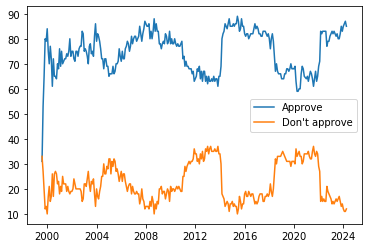

In [18]:
# по оси x – даты
# по оси y – ответы да/нет
# графики и так будут разного цвета
# label – чтобы линия и цвет добавились в легенду,
# которую мы добавили через legend()

plt.plot(x, yes, label = "Approve");
plt.plot(x, no, label = "Don't approve");
plt.legend();

График, в целом, понятный, но довольно маленький. Давайте построим его более продвинутым способом.

Вообще график `matplotlib` состоит из двух частей:

* само изображение, которое потом можно выгрузить в файл (обычно сохраняется в переменную `fig`);
* поле с осями, внутри которого строится график (обычно сохраняется в переменную `ax`).

Все изменения мы вносим в поле с осями («канву» графика): в него помещаем график определённого типа, добавляем подписи к осям, настраиваем шрифты и цвета и прочее, осуществляем это, применяя методы к объекту `ax`. А по завершении работы готовое изображение `fig` экспортируем в файл PNG/JPEG/PDF.

Так, мы можем воспользоваться функцией `subplots()` и сообщить Python, что мы хотим получить картинку размера 16 на 9 дюймов с разрешением 300 точек на дюйм:

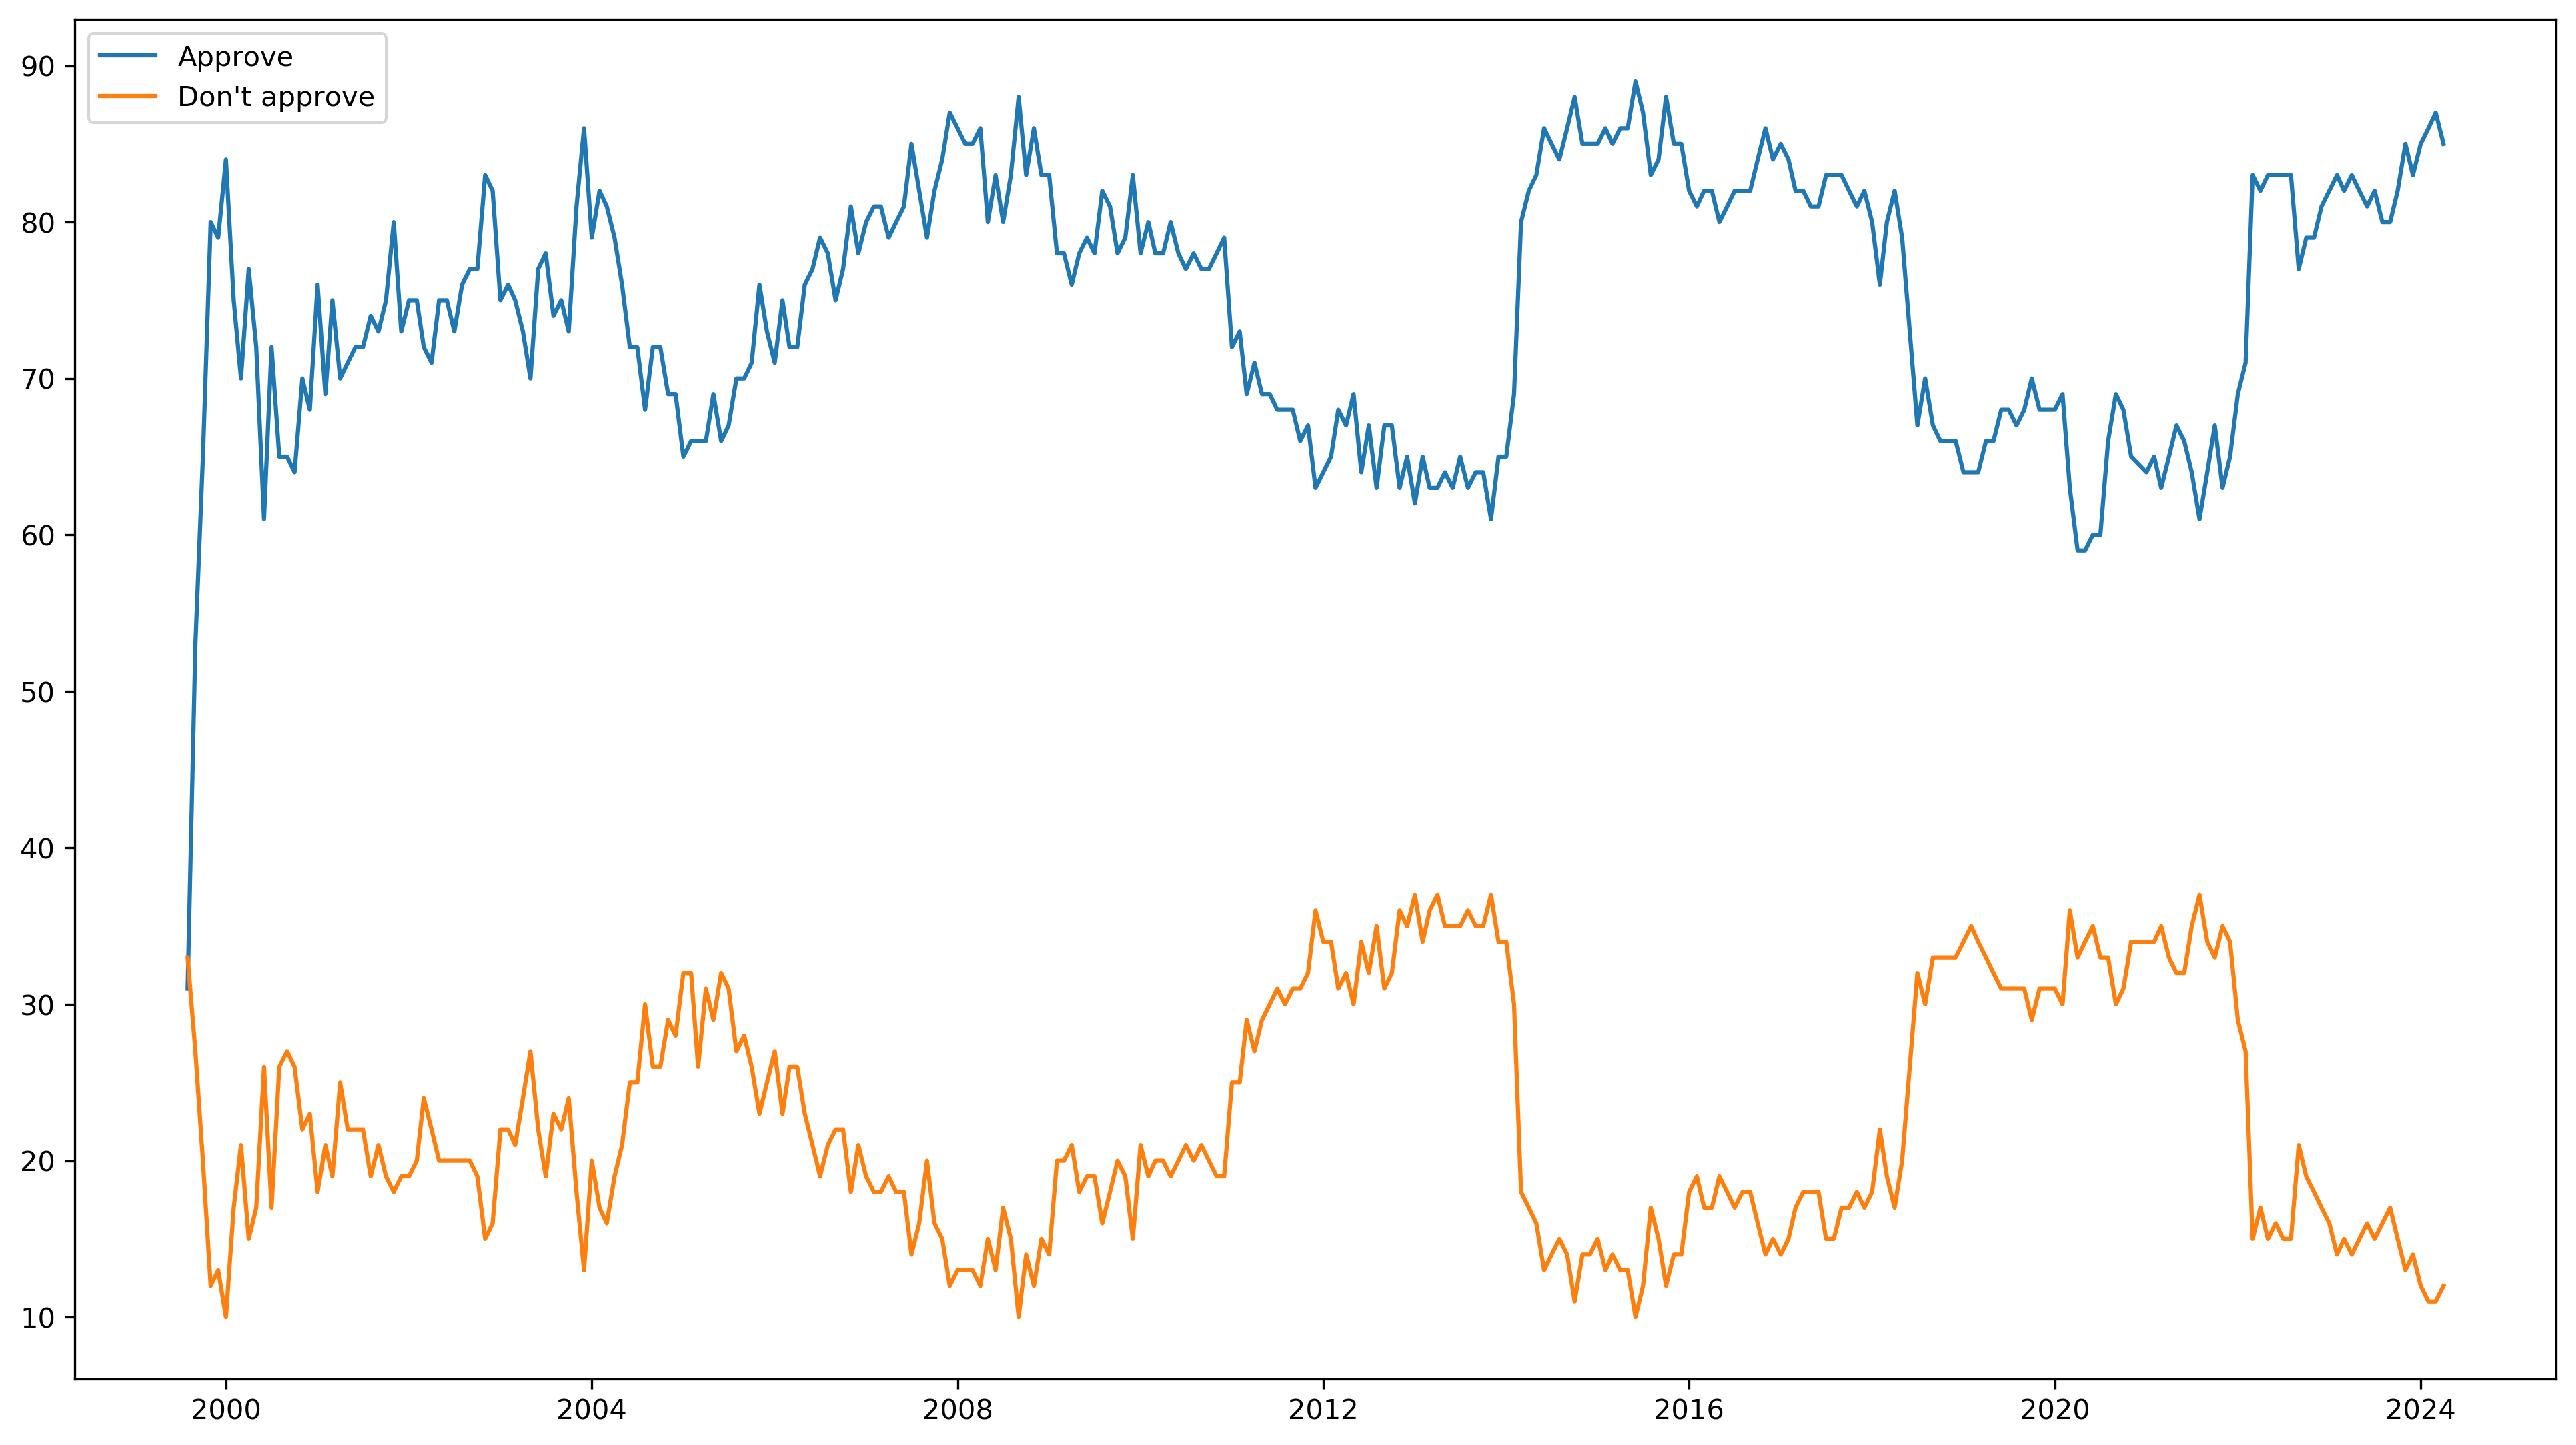

In [19]:
# множественное присваивание, subplots() возвращает сразу 2 элемента
# первый – картинка, второй – канва для ее отрисовки

fig, ax = plt.subplots(figsize = (16, 9), dpi = 300) 

# код – как выше, только методы применяем уже к ax

ax.plot(x, yes, label = "Approve");
ax.plot(x, no, label = "Don't approve");
ax.legend();

Добавим координатную сетку:

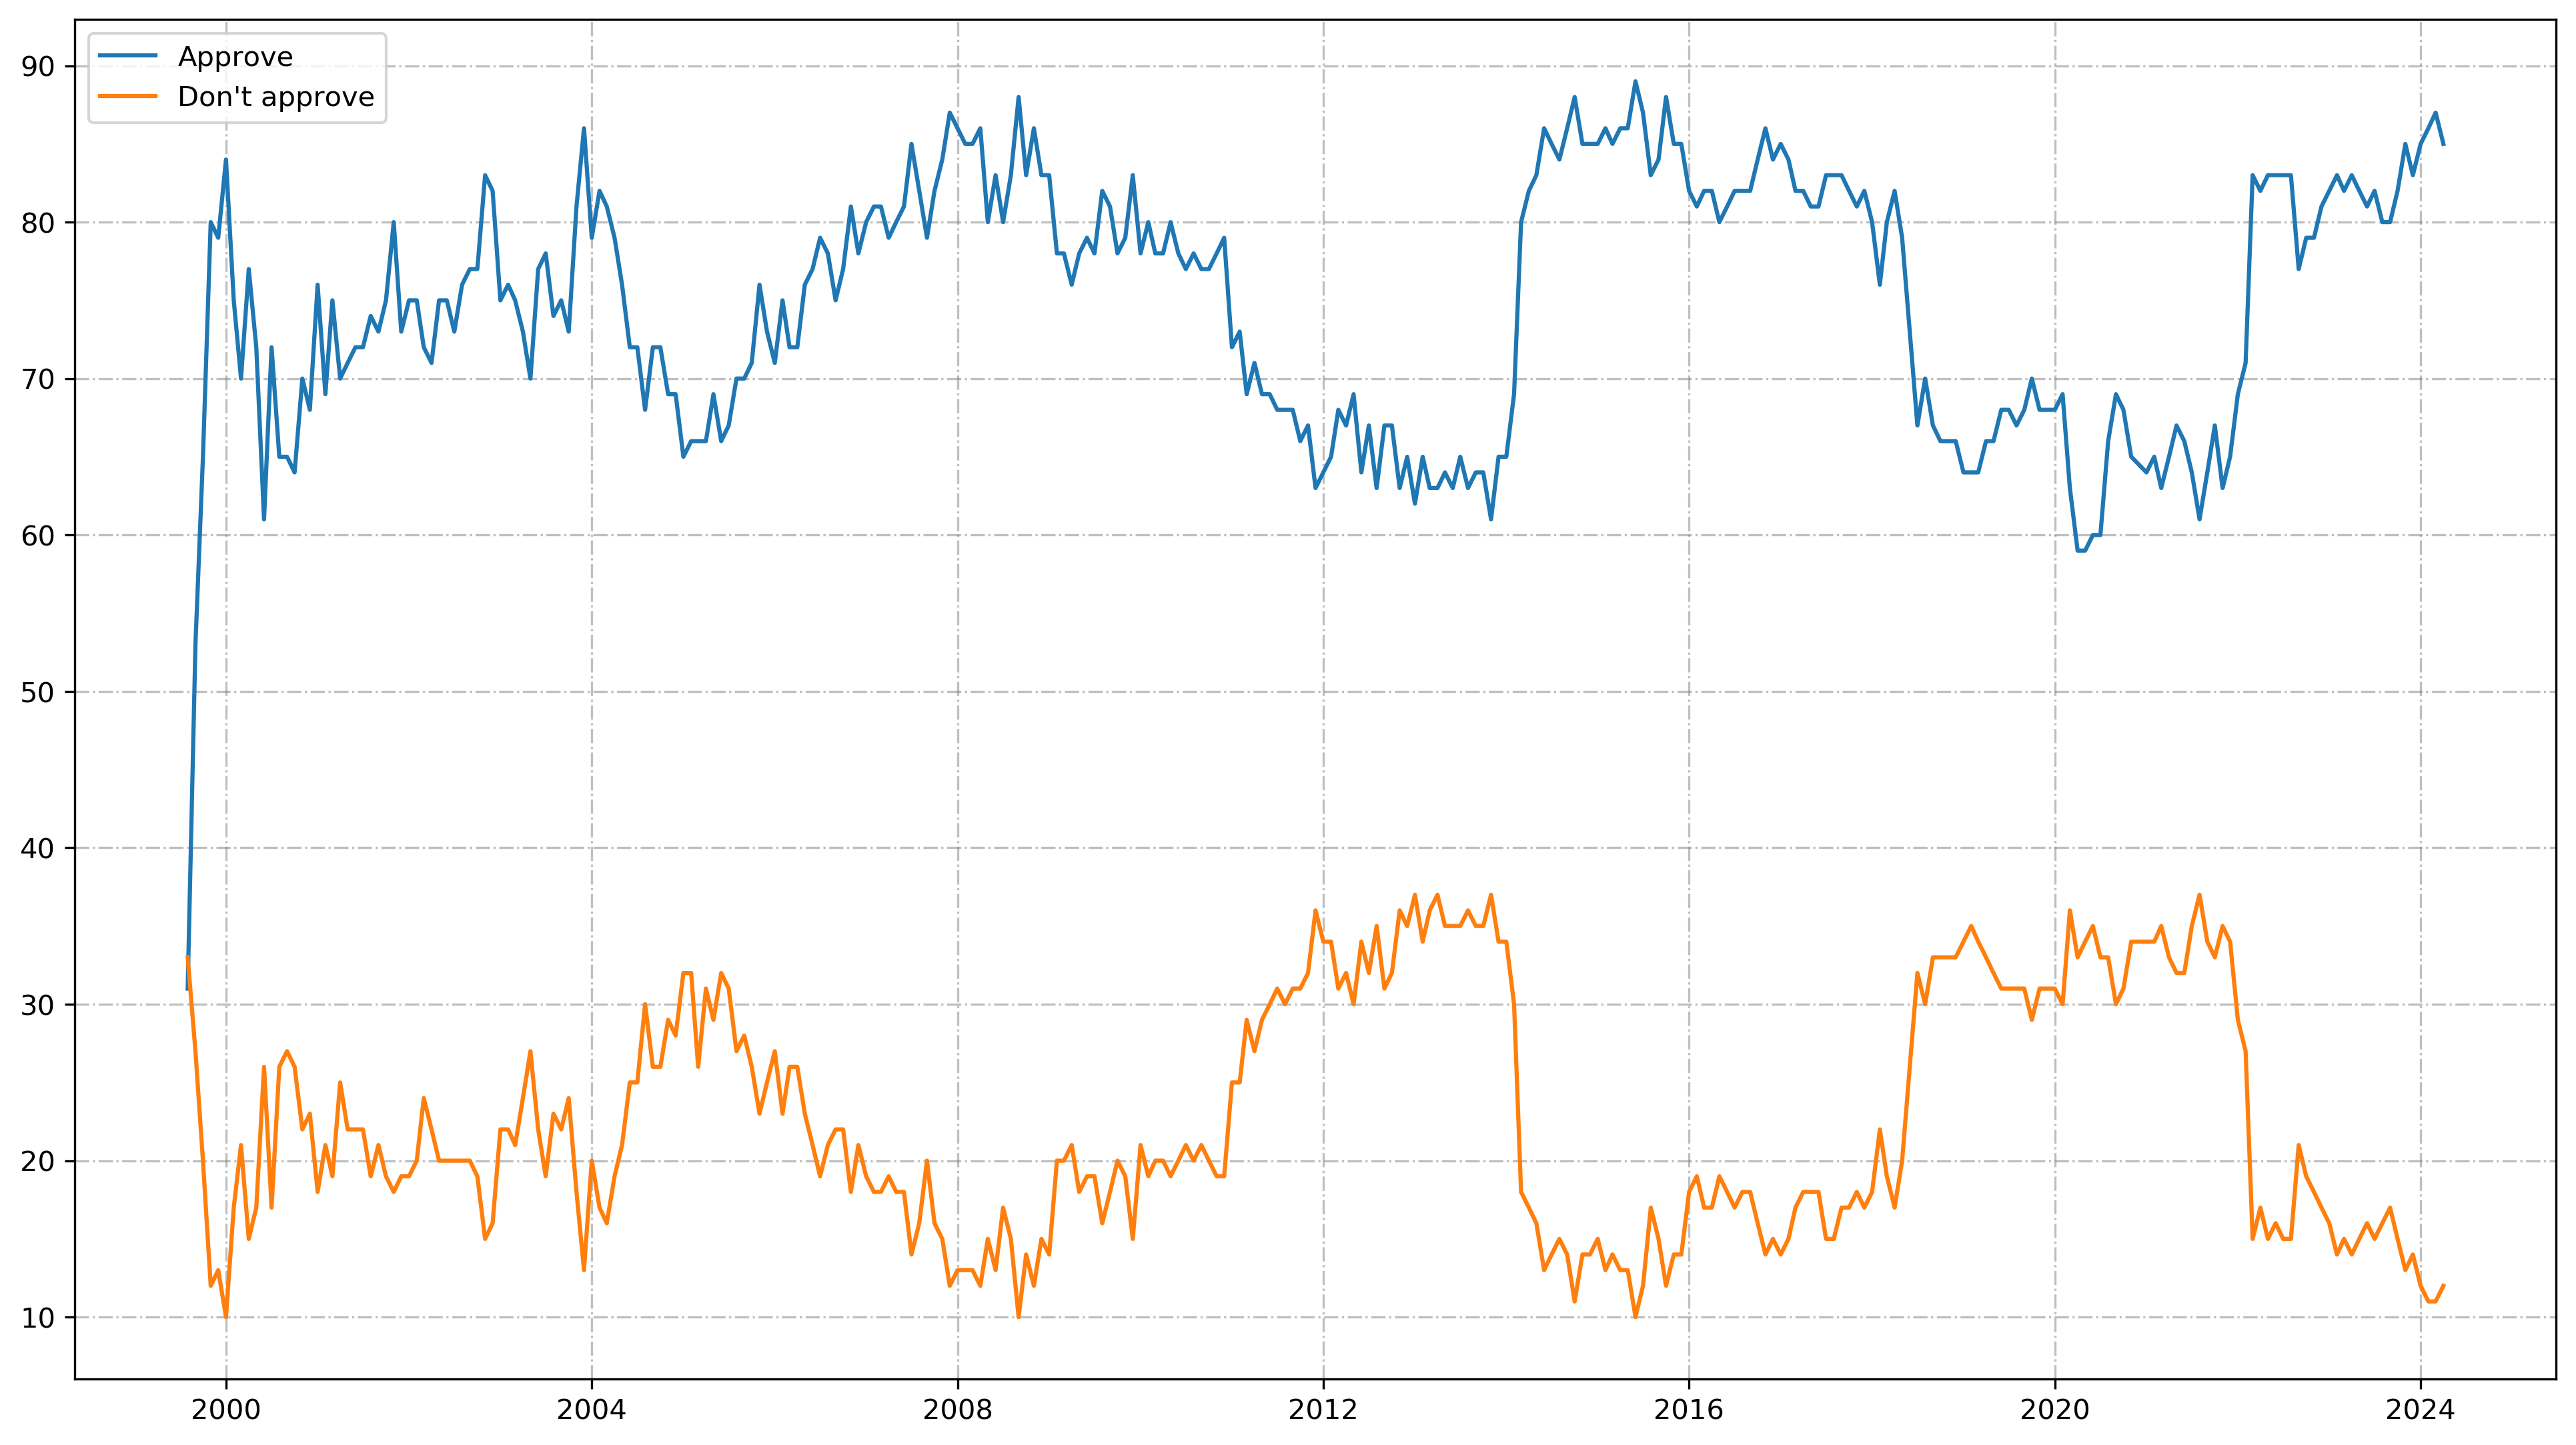

In [20]:
fig, ax = plt.subplots(figsize = (16, 9), dpi = 300) 

ax.plot(x, yes, label = "Approve");
ax.plot(x, no, label = "Don't approve");
ax.legend();

# цвет сетки, тип линии, прозрачность (alpha)

ax.grid(color = "grey", linestyle = "-.", alpha = 0.5);

Увеличим число делений, чтобы все годы были отмечены на горизонтальной оси. Воспользуемся функцией `date_range()` из pandas, которая позволяет создавать интервалы типа *дата-время* (подробнее см. [здесь](https://pandas.pydata.org/docs/reference/api/pandas.date_range.html)):

In [21]:
# ищем минимальную дату в наших данных 1999-08-01

df["date"].min()

Timestamp('1999-08-01 00:00:00')

In [22]:
# минимальная дата = стартовая точка
# выбираем шаг, равный году, и отсчитываем 26 лет
# (AS-AUG - Annual frequency, year Starts in AUGust)

xx = pd.date_range(df["date"].min(), periods=26, freq='AS-AUG')
print(xx)

DatetimeIndex(['1999-08-01', '2000-08-01', '2001-08-01', '2002-08-01',
               '2003-08-01', '2004-08-01', '2005-08-01', '2006-08-01',
               '2007-08-01', '2008-08-01', '2009-08-01', '2010-08-01',
               '2011-08-01', '2012-08-01', '2013-08-01', '2014-08-01',
               '2015-08-01', '2016-08-01', '2017-08-01', '2018-08-01',
               '2019-08-01', '2020-08-01', '2021-08-01', '2022-08-01',
               '2023-08-01', '2024-08-01'],
              dtype='datetime64[ns]', freq='AS-AUG')


Помещаем полученную последовательность в подписи к осям:

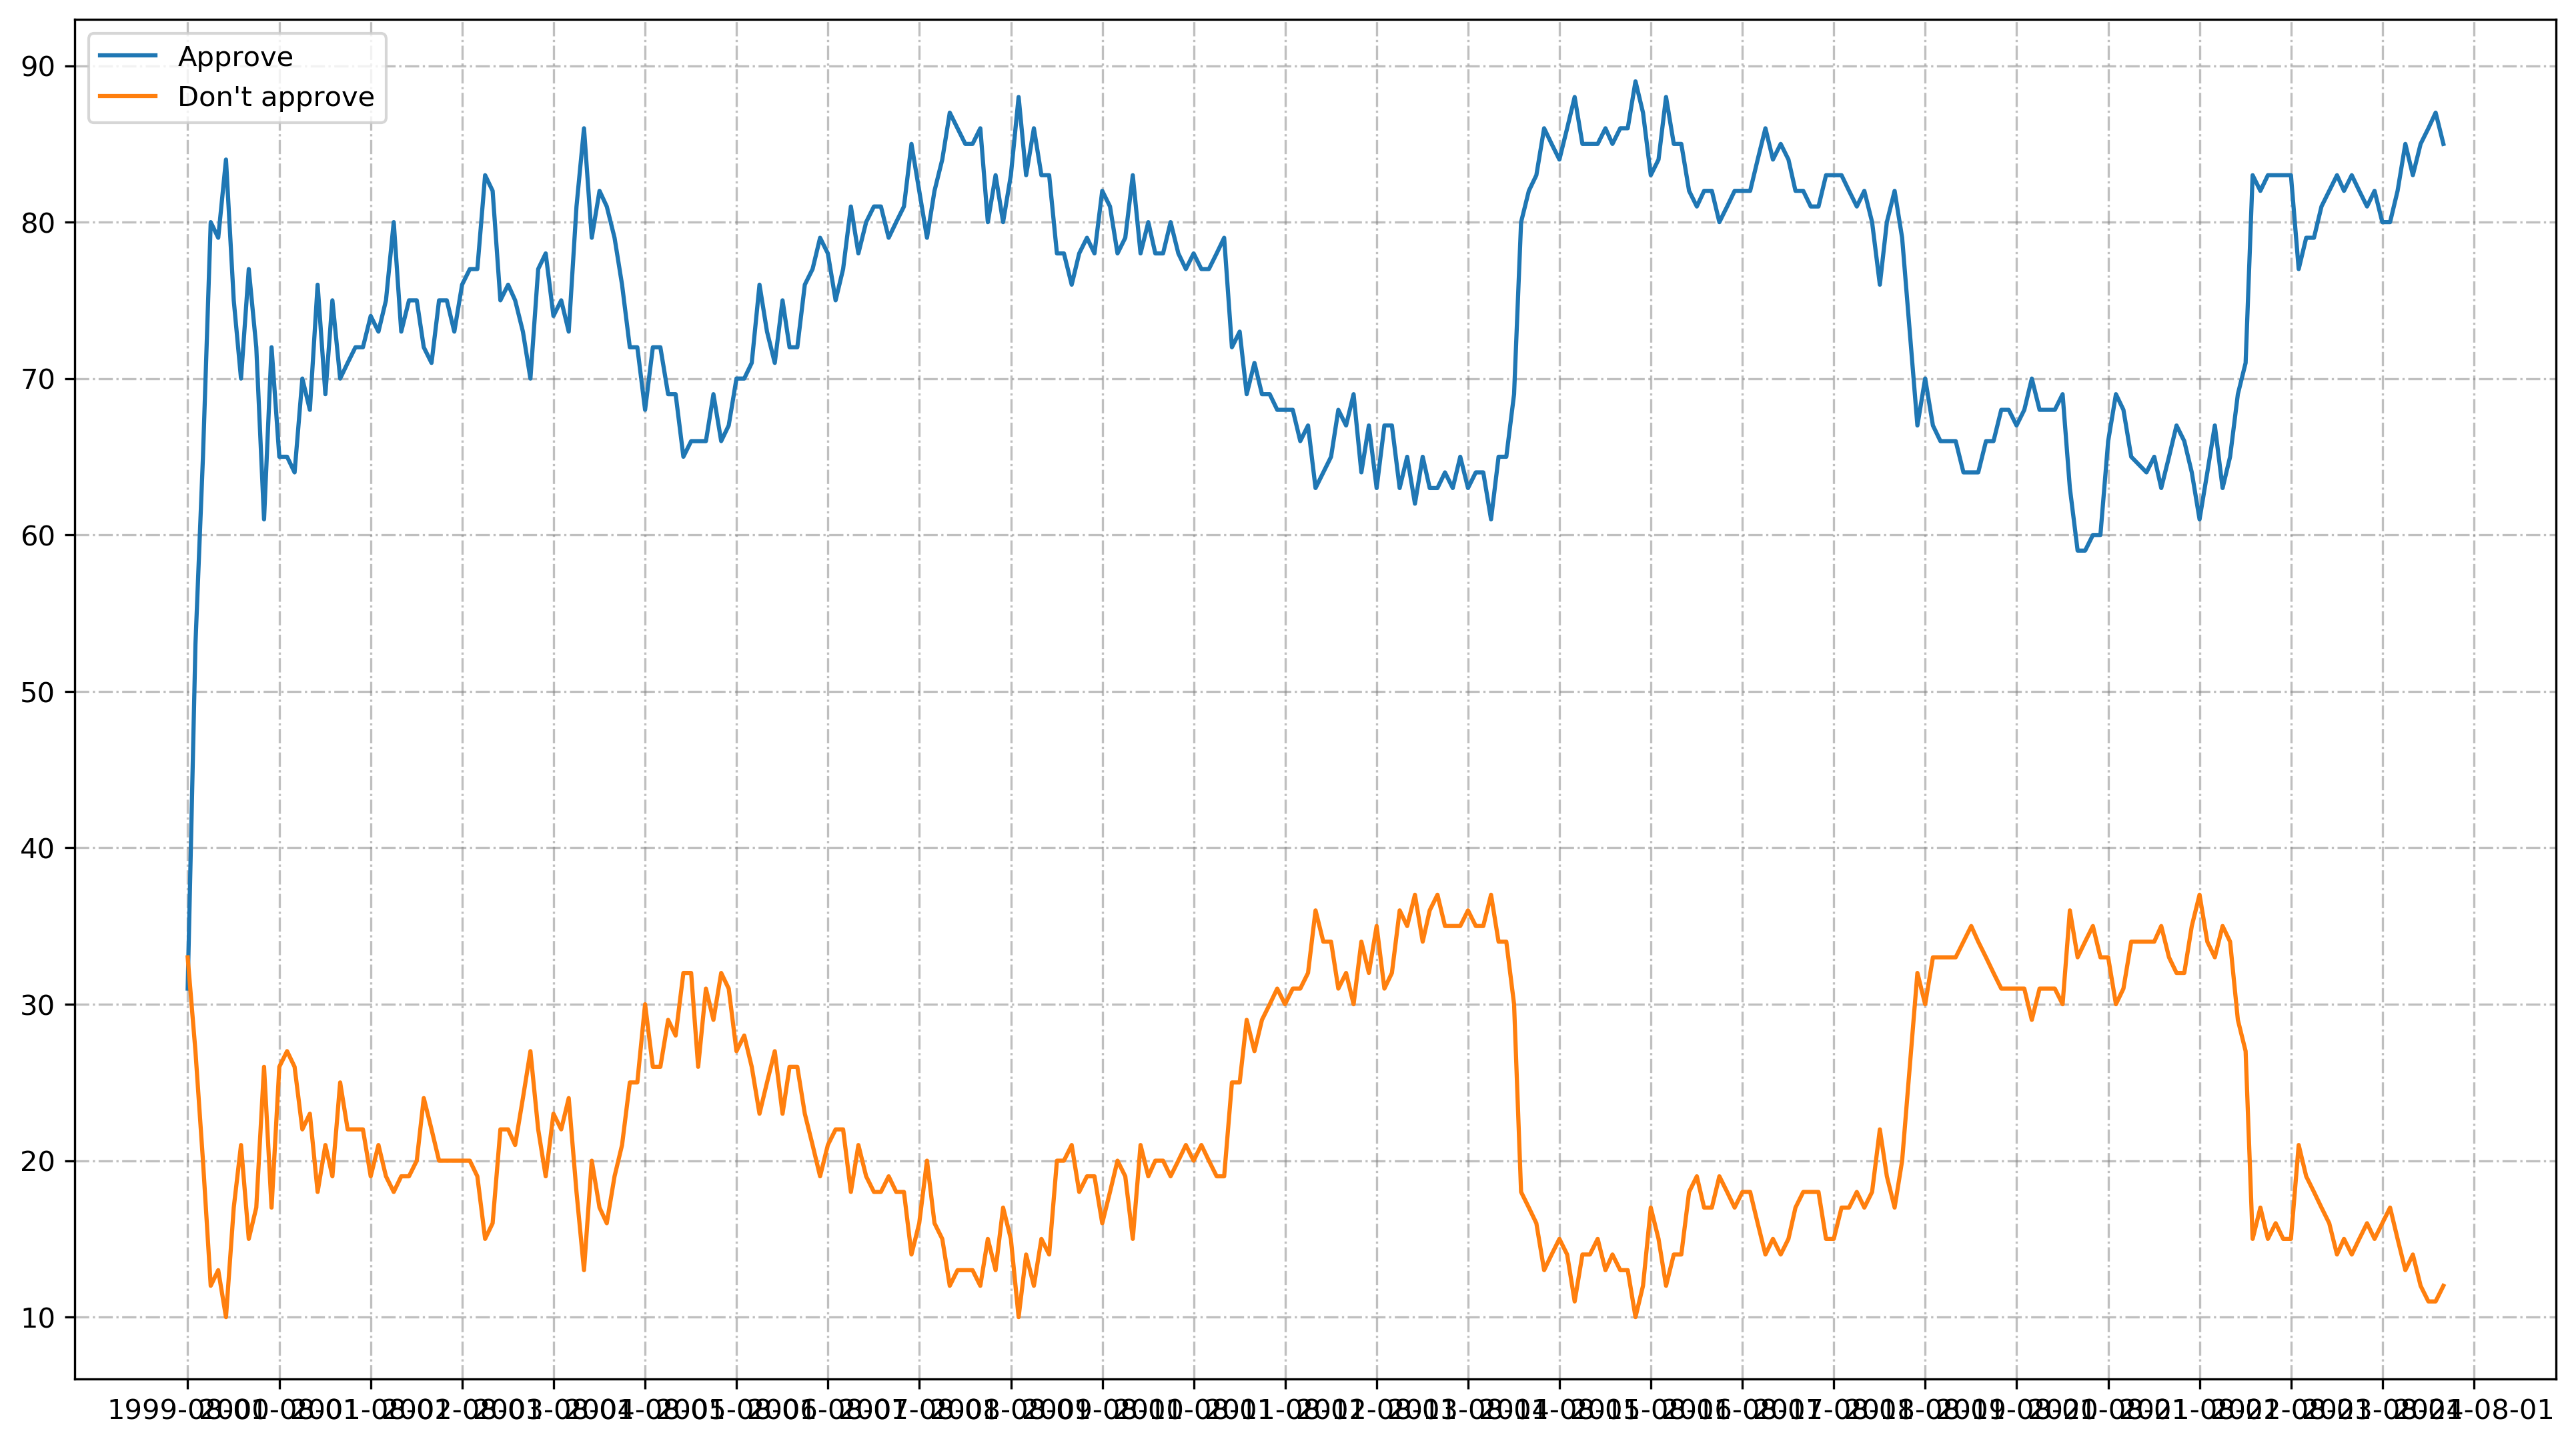

In [23]:
fig, ax = plt.subplots(figsize = (16, 9), dpi = 300) 

ax.plot(x, yes, label = "Approve");
ax.plot(x, no, label = "Don't approve");
ax.legend();
ax.grid(color = "grey", linestyle = "-.", alpha = 0.5);

# xticks – засечки по оси x
ax.set_xticks(xx);

Осталось повернуть подписи по горизонтальной оси:

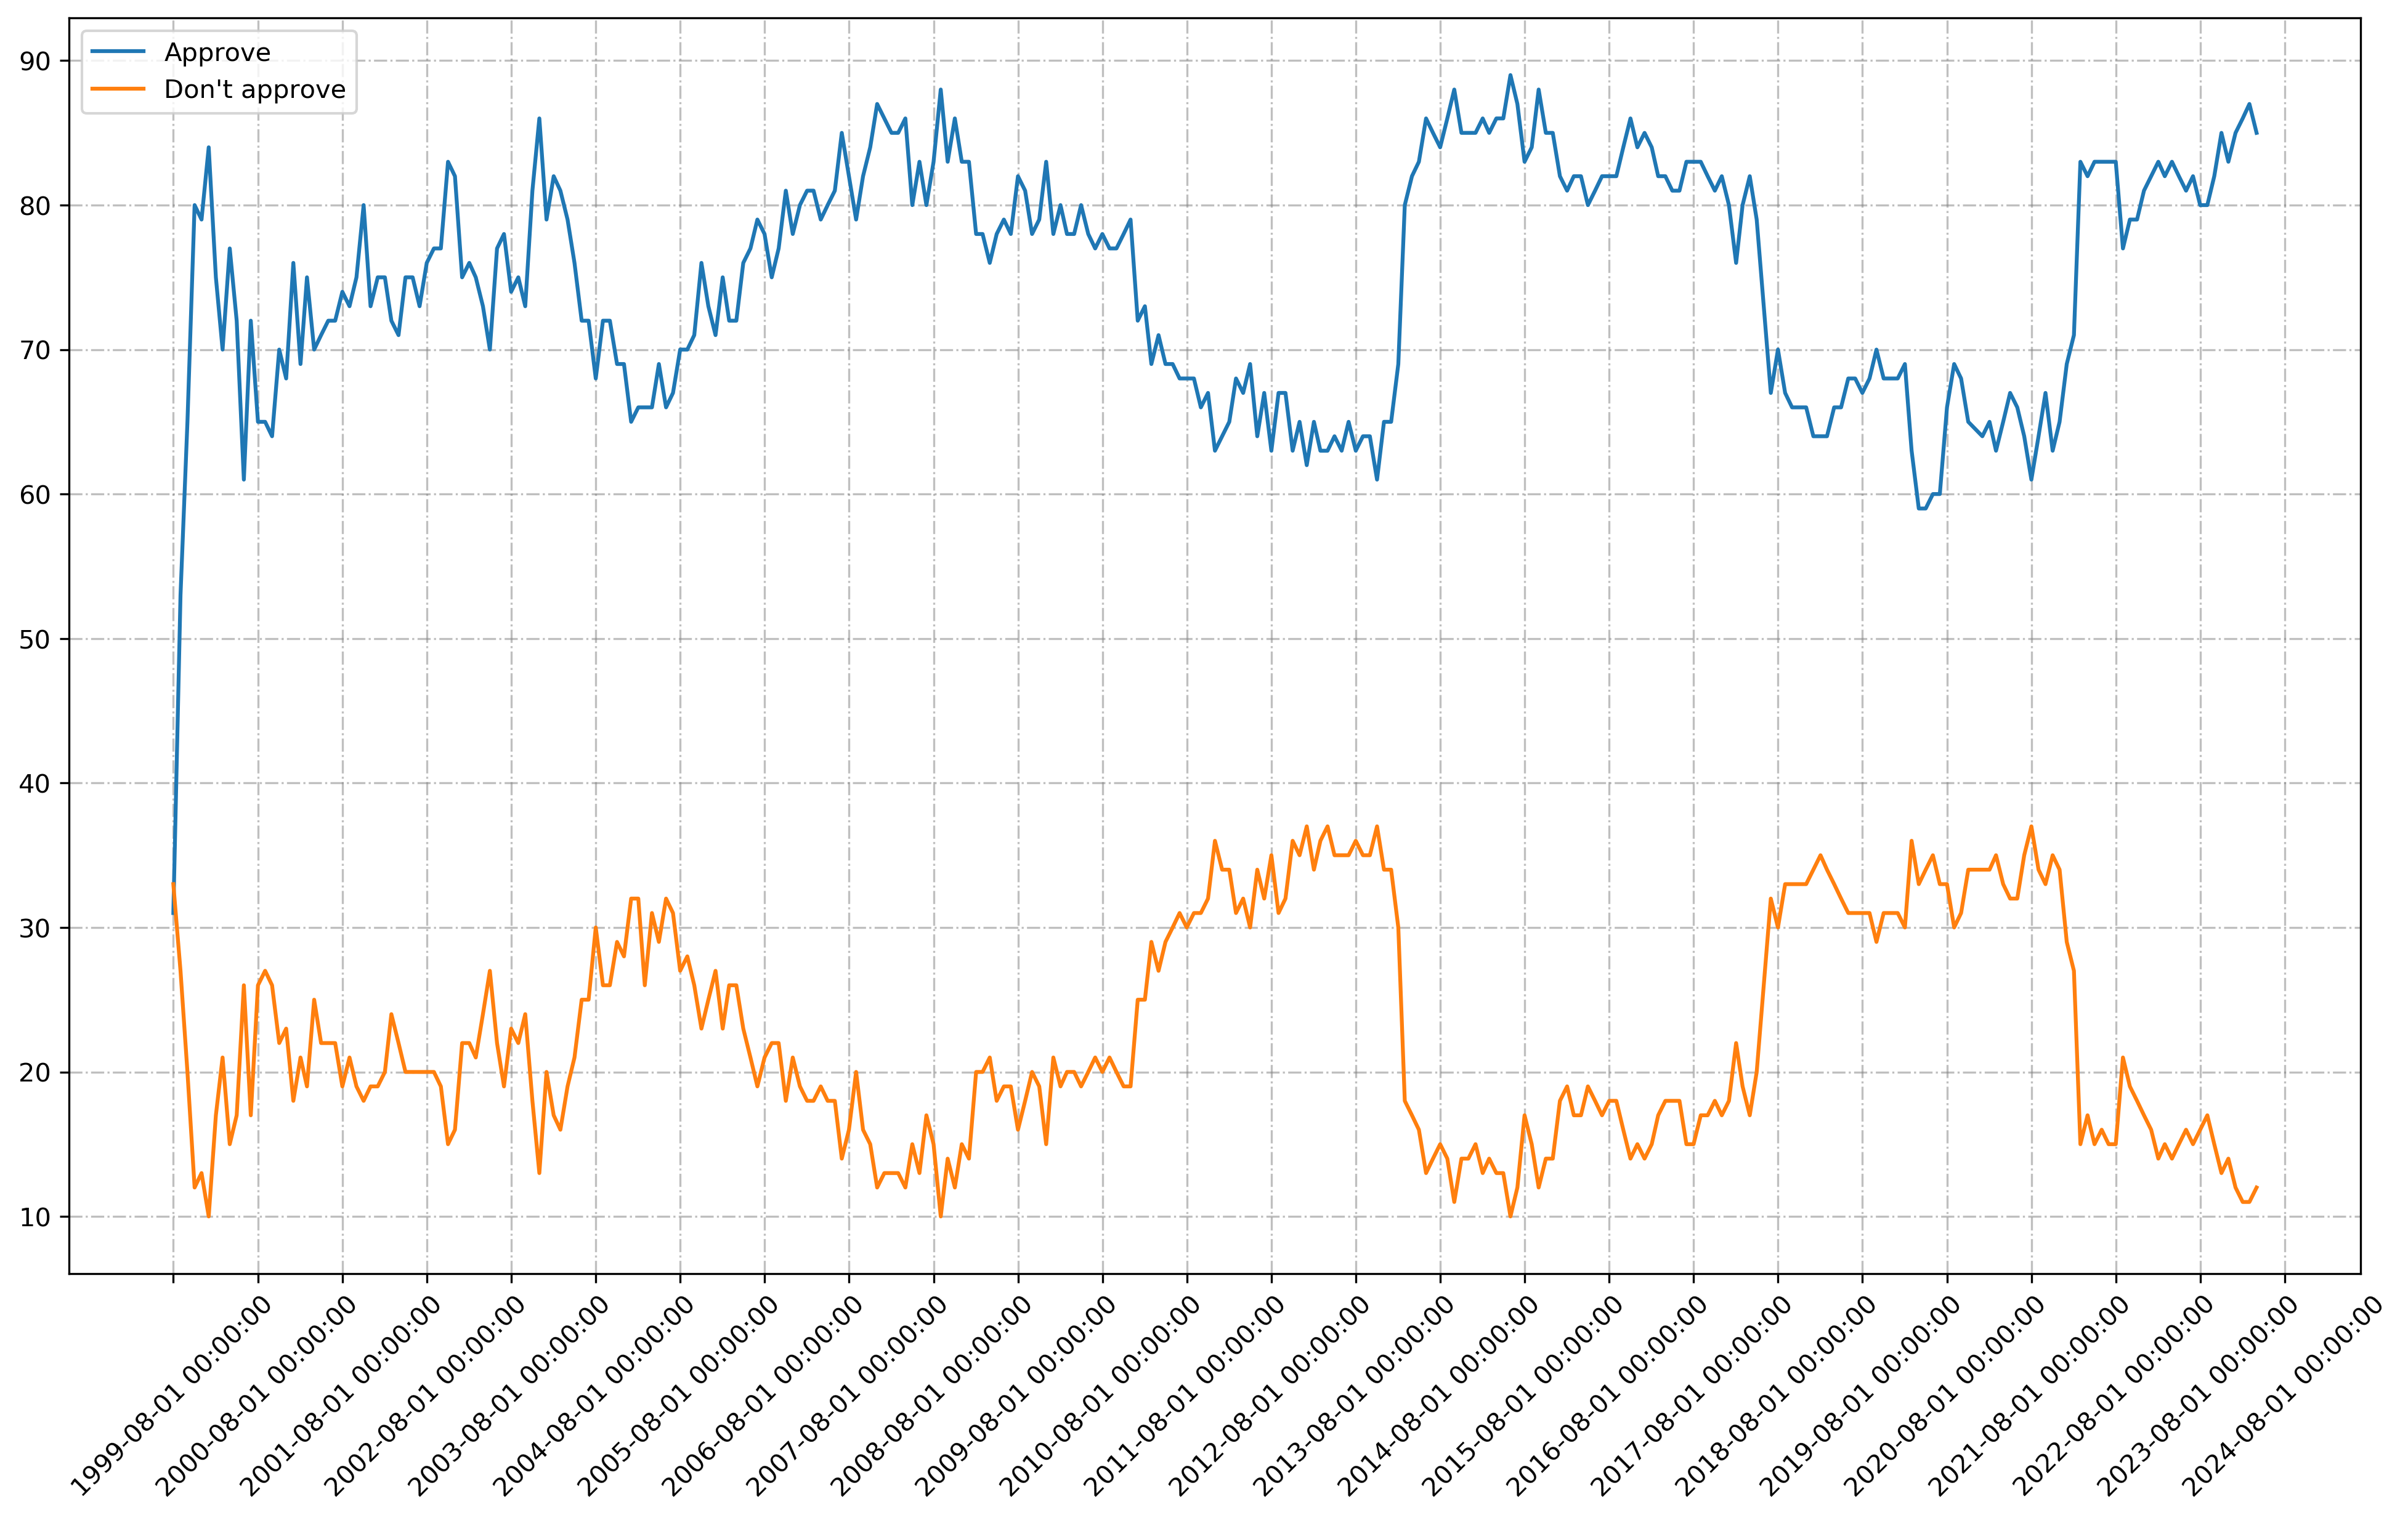

In [24]:
fig, ax = plt.subplots(figsize = (16, 9), dpi = 300) 

ax.plot(x, yes, label = "Approve");
ax.plot(x, no, label = "Don't approve");
ax.legend();
ax.grid(color = "grey", linestyle = "-.", alpha = 0.5);

# все те же значения из xx
# но уже под углом 45 градусов
ax.set_xticks(xx);
ax.set_xticklabels(xx, rotation = 45);

И отформатировать подписи – убрать время и день, оставить месяц в текстовом виде, снова возвращаемся к форматированию дат:

In [25]:
# месяц полностью и год

xx_labels = xx.strftime("%B %Y")
print(xx_labels)

Index(['August 1999', 'August 2000', 'August 2001', 'August 2002',
       'August 2003', 'August 2004', 'August 2005', 'August 2006',
       'August 2007', 'August 2008', 'August 2009', 'August 2010',
       'August 2011', 'August 2012', 'August 2013', 'August 2014',
       'August 2015', 'August 2016', 'August 2017', 'August 2018',
       'August 2019', 'August 2020', 'August 2021', 'August 2022',
       'August 2023', 'August 2024'],
      dtype='object')


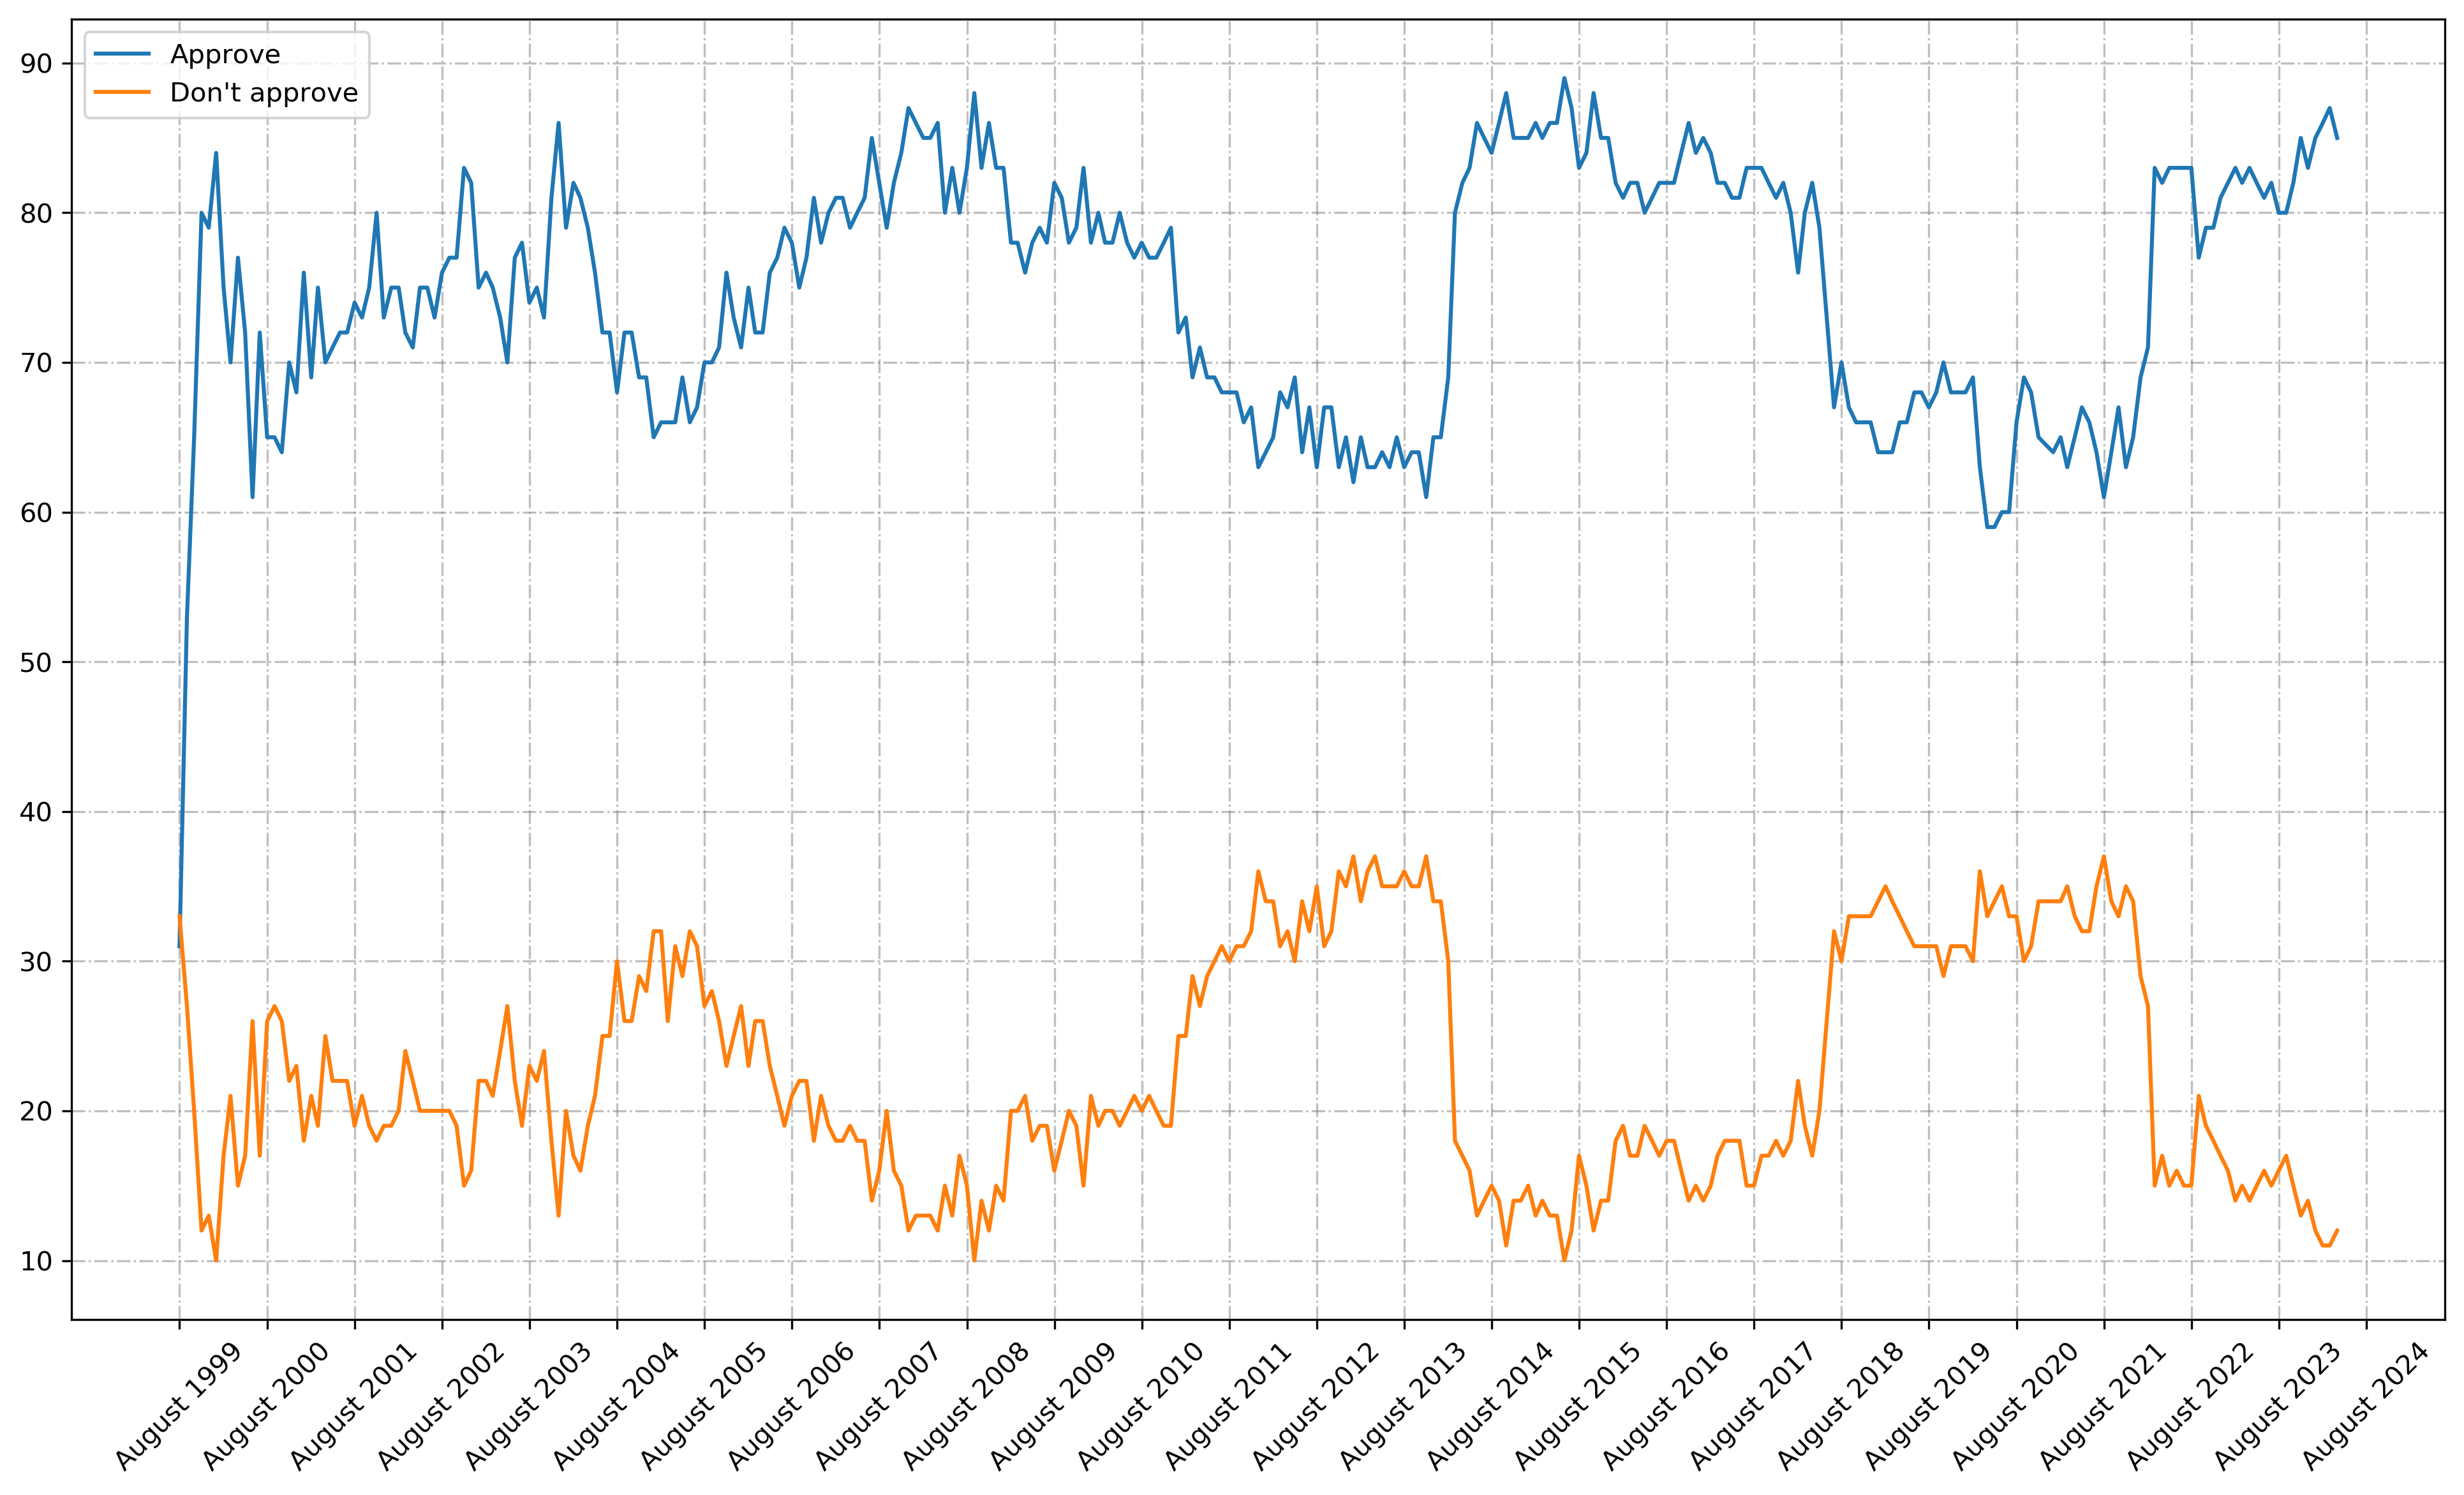

In [26]:
fig, ax = plt.subplots(figsize = (16, 9), dpi = 300) 

ax.plot(x, yes, label = "Approve");
ax.plot(x, no, label = "Don't approve");
ax.legend();
ax.grid(color = "grey", linestyle = "-.", alpha = 0.5);

# засечки xticks прежние
# подписи из xx_labels

ax.set_xticks(xx);
ax.set_xticklabels(xx_labels, rotation = 45);

Теперь осталось выгрузить изображение в файл – объект `fig`:

In [27]:
fig.savefig("dynamic.png")

В рабочей папке (где лежит текущий ipynb-файл) должен появиться файл `dynamic.png`.